# __GAN Monet Style Transfer Project__

Import Libraries

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization, LeakyReLU,Flatten, Dropout,Input,MaxPooling2D
from tensorflow.keras.backend import clear_session
import cv2
import os
import time


In [5]:
# Check to ensure that GPU acceleration is working properly
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


## The Problem

The purpose of this project is to create a machine learning model capable of learning the style of a particular artist (Monet in this case), and directly apply it to real-world images, using Generative Adversarial Networks (GANs). The use of GANs for style transfer are a very flexible tool that can be applied to a wide range of applications. GAN style transfer is used heavily in our everyday lives for all kinds of image processing, such as social media filters, image enhancement, and restorations. 

## __The Data__

The data available for this problem is composed of two separate sets of images. The first set of images contains 300 scans of monet paintings that we want to extract the style of. The second set of images are real-life photos that were taken, that we want to apply Monet's style to. Both the monet paintings and the real-life photos are in 3-channel RGB, and are 256x256 pixels for each individual photo. This results in the following sizes:

-Monet paintings: 3 x 256 x 256 x 300, total size: 0.078MB, or 78KB

-Photos: 3 x 256 x 256 x 300, total size: 1.75 MB

In [6]:
data_dir = "A:/GAN_project/dataset/"
train_files = os.listdir(data_dir + "monet_jpg/")
photo_files = os.listdir(data_dir + "photo_jpg/")

Below we get the file sizes

In [7]:
print("size of monet paintings directory: {:.3f} MB".format(\
    os.path.getsize(data_dir + "monet_jpg/")/(1024**2)))
print("size of photos directory: {:.3f} MB".format(\
    os.path.getsize(data_dir + "photo_jpg/")/(1024**2)))

size of monet paintings directory: 0.078 MB
size of photos directory: 1.750 MB


Importing the data

In [8]:
#each image is pulled via its filename, read, and appended to a list
train_images = []
for filename in train_files:

    path = data_dir + "monet_jpg/" + filename
    image = cv2.imread(path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    train_images.append(image)

photo_images = []
for filename in photo_files:

    path = data_dir + "photo_jpg/" + filename
    image = cv2.imread(path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    photo_images.append(image)

#converted to numpy array at the end of the process for easier processing
train_images = np.array(train_images)
photo_images = np.array(photo_images)

## Exploratory Data Analysis

The EDA for this project is done with the purpose of ensuring that there aren't any particular images within the training dataset capable of interfering with the style extraction the GAN hopes to employ, such as one image that is almost entirely all white, all black, etc., which may potentially interfere with the training of the GAN, and lead it astray. This will also be a potentially interesting distribition to look at following the style transfer, to see if the modified images become more similar, or other features emerge.

To start, let's just look at the first images in each data set

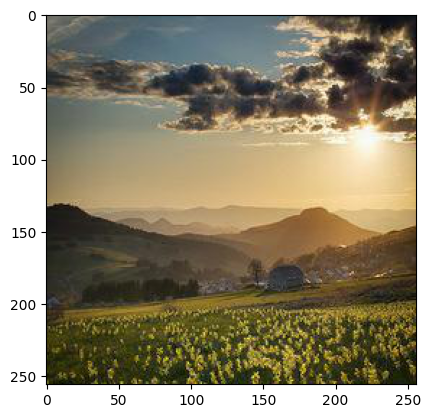

In [151]:
#first image set image
plt.imshow(photo_images[0])

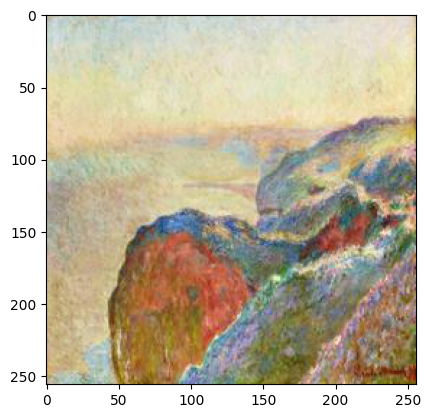

In [152]:
#first monet image
plt.imshow(train_images[0])

Below, the data is ordered into new variables based on color value:

-all_v_D contains every RGB value for color X for dataset D, separated into [red,green,blue] respectively

-all_2D_D flattens each 256x256 image, and stores it in the main list, making it 2D for each channel

-avg_X_D contains the average value for individual images', nested by color channels for dataset D

-std_X_D is the same, but for standard deviation for dataset D, nested by color channels

In [9]:
all_v_monet = [train_images[:,:,:,i] for i in range(3)]
all_v_photos = [photo_images[:,:,:,i] for i in range(3)]

all_2D_monet = [chan.reshape(chan.shape[0],-1) for chan in all_v_monet]
all_2D_photos = [chan.reshape(chan.shape[0],-1) for chan in all_v_photos]

avg_monet = [np.mean(channel2D,axis = 1) for channel2D in all_2D_monet]
avg_photos = [np.mean(channel2D,axis = 1) for channel2D in all_2D_photos]

std_monet = [np.std(channel2D,axis = 1) for channel2D in all_2D_monet]
std_photos = [np.std(channel2D,axis = 1) for channel2D in all_2D_photos]

Below are visualizations of all color values for both the monet dataset and the photoset respectively.

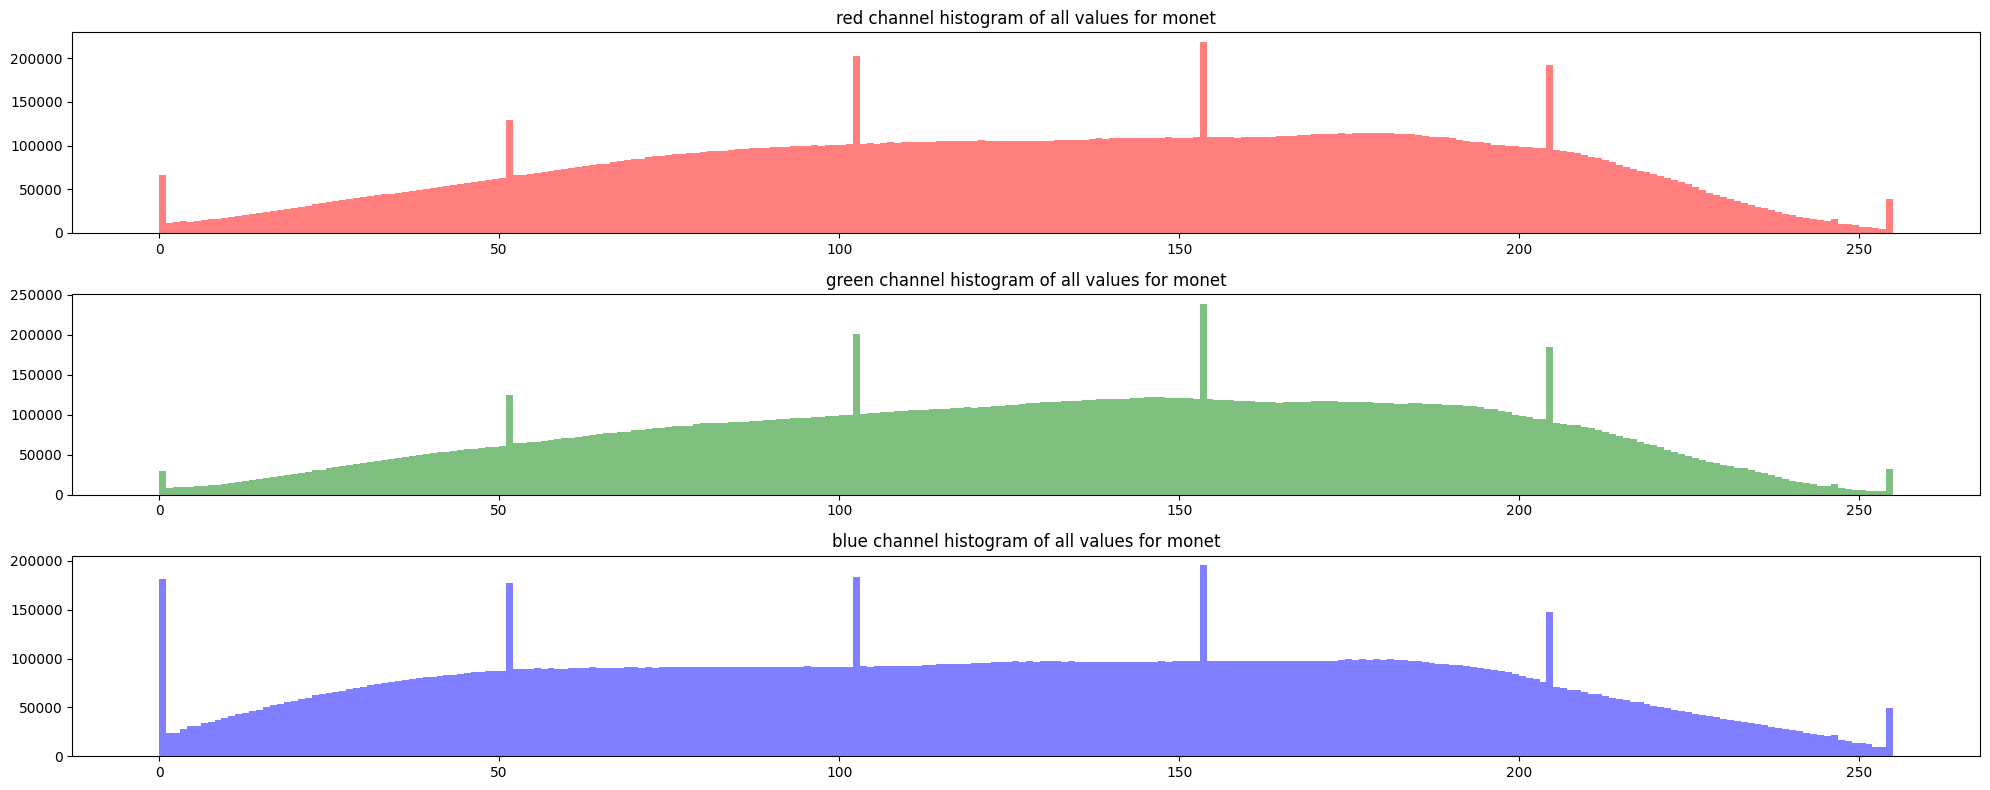

In [10]:
fig, axs = plt.subplots(3,1, figsize = (20,8))
channel_names = ["red","green","blue"]
for i,name in enumerate(channel_names):
    axs[i].hist(all_v_monet[i].flatten(),color = name, alpha = 0.5, bins = 250)
    axs[i].set_title(name + " channel histogram of all values for monet")
plt.tight_layout()
plt.show()

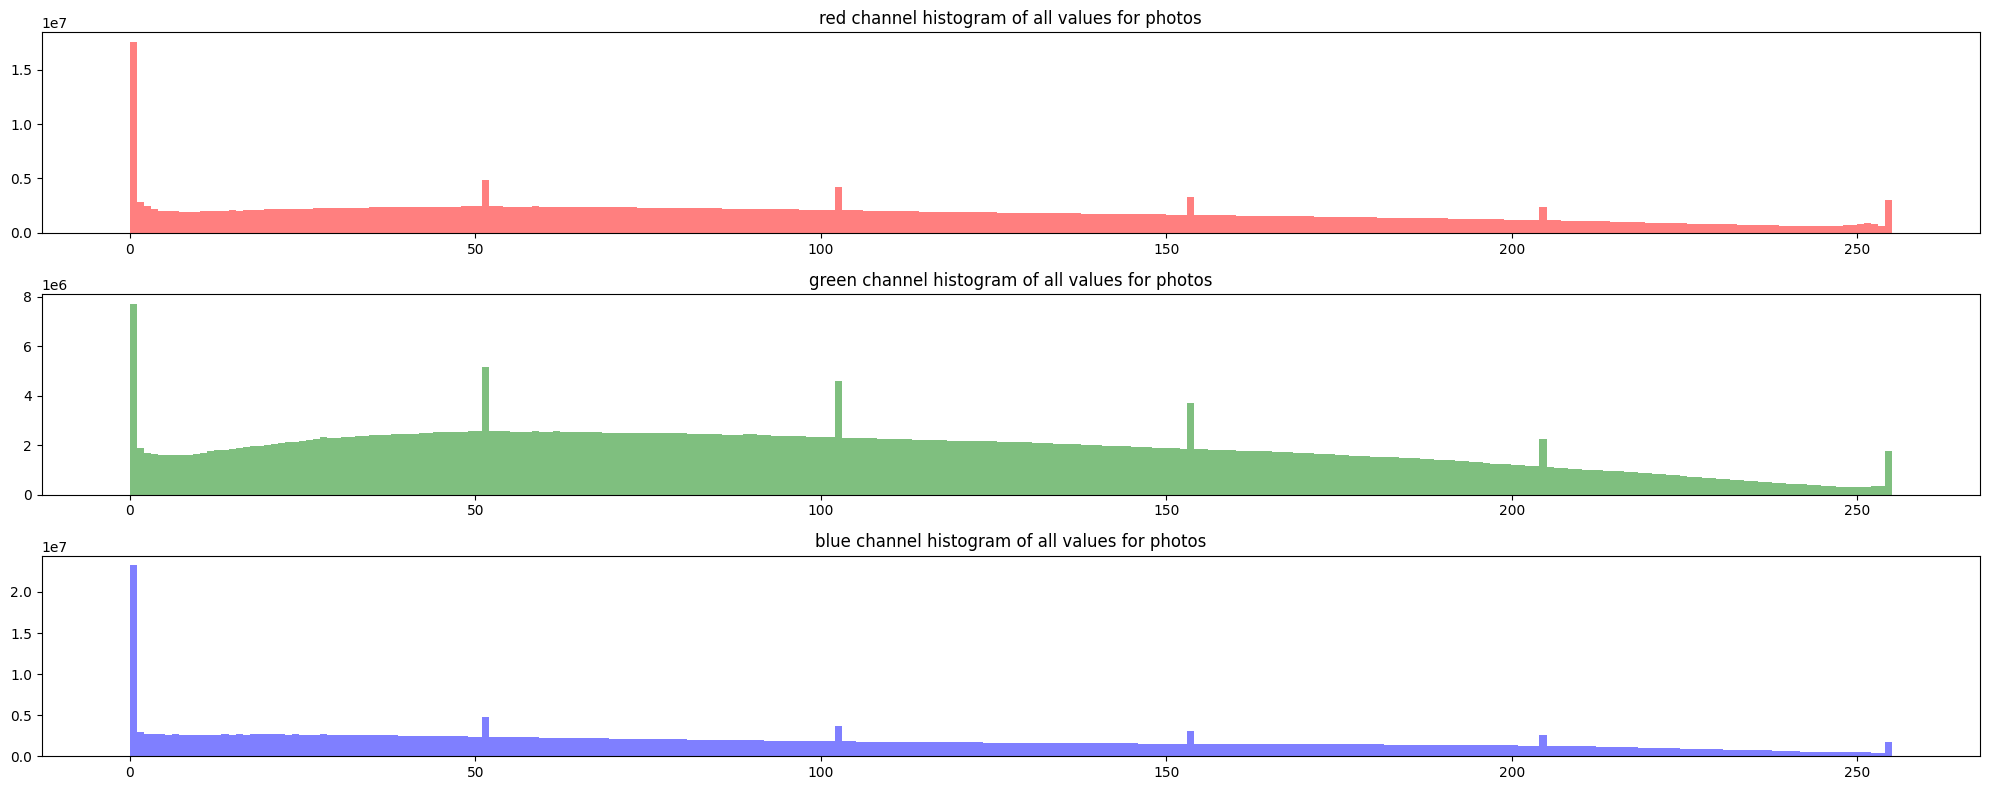

In [11]:
fig, axs = plt.subplots(3,1, figsize = (20,8))
channel_names = ["red","green","blue"]
for i,name in enumerate(channel_names):
    axs[i].hist(all_v_photos[i].flatten(),color = name, alpha = 0.5, bins = 250)
    axs[i].set_title(name + " channel histogram of all values for photos")
plt.tight_layout()
plt.show()

Interestingly, the photos dataset seems to be the one containing more anomalous values, with many such values of pure whitespace. Hopefully the other metrics will give us a clearer picture of just what is going on with this.

below is the same visualization, but now for the average image values.

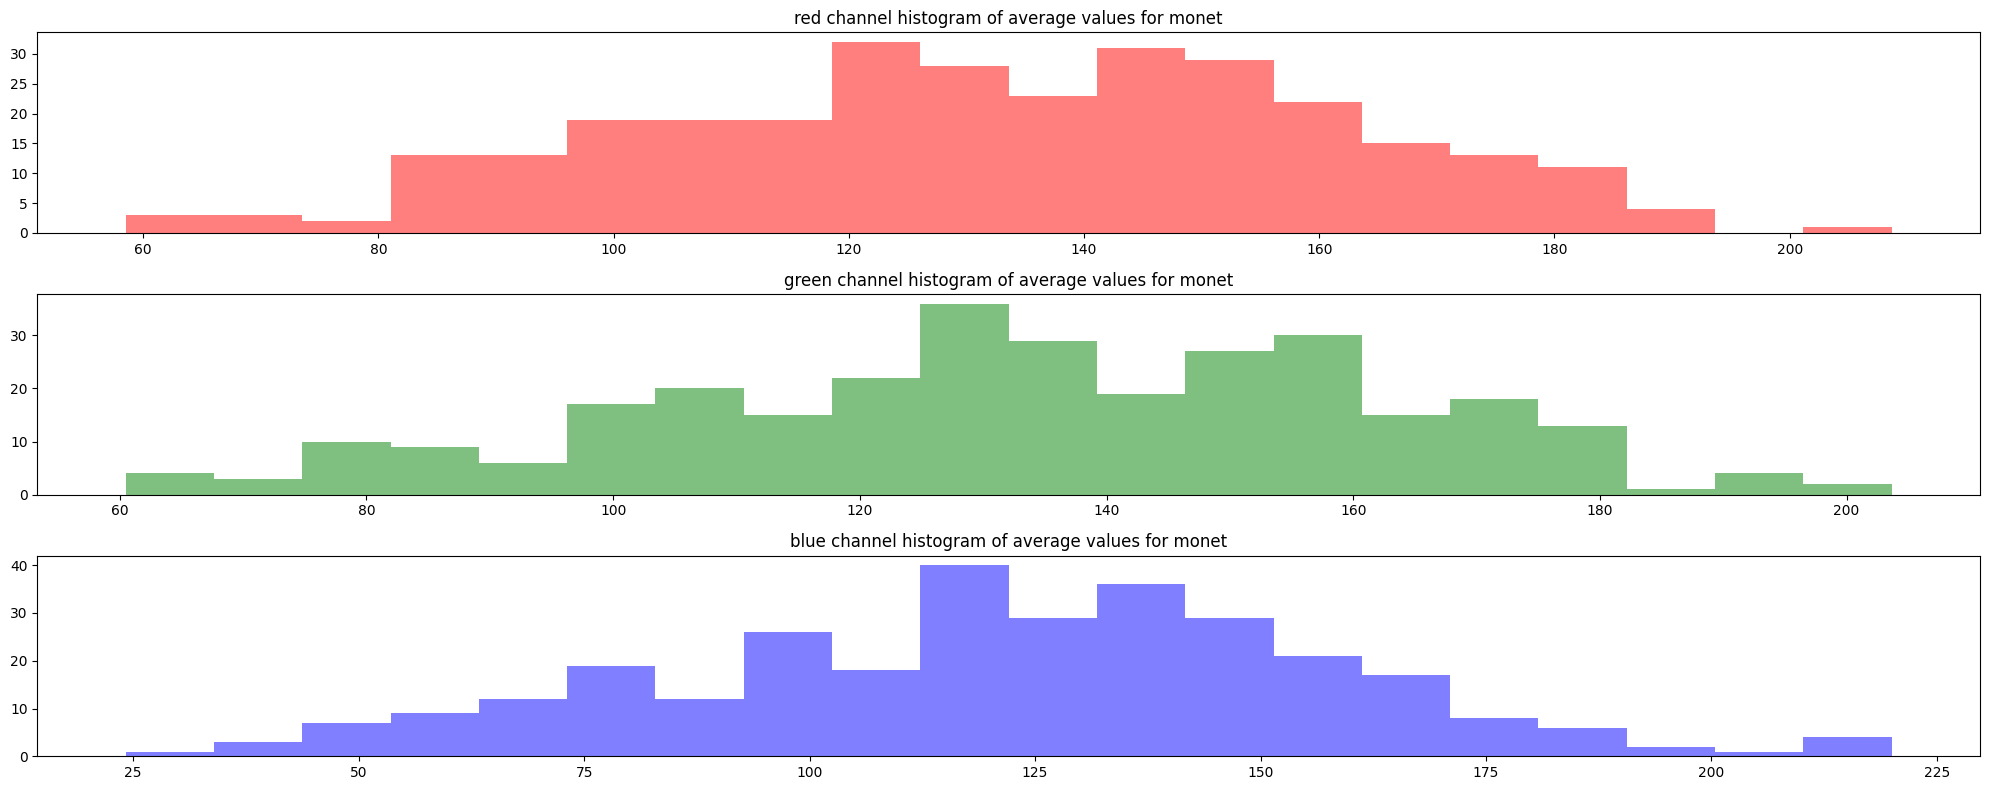

In [12]:
fig, axs = plt.subplots(3,1, figsize = (20,8))
channel_names = ["red","green","blue"]
for i,name in enumerate(channel_names):
    axs[i].hist(avg_monet[i].flatten(),color = name, alpha = 0.5, bins = 20)
    axs[i].set_title(name + " channel histogram of average values for monet")
plt.tight_layout()
plt.show()

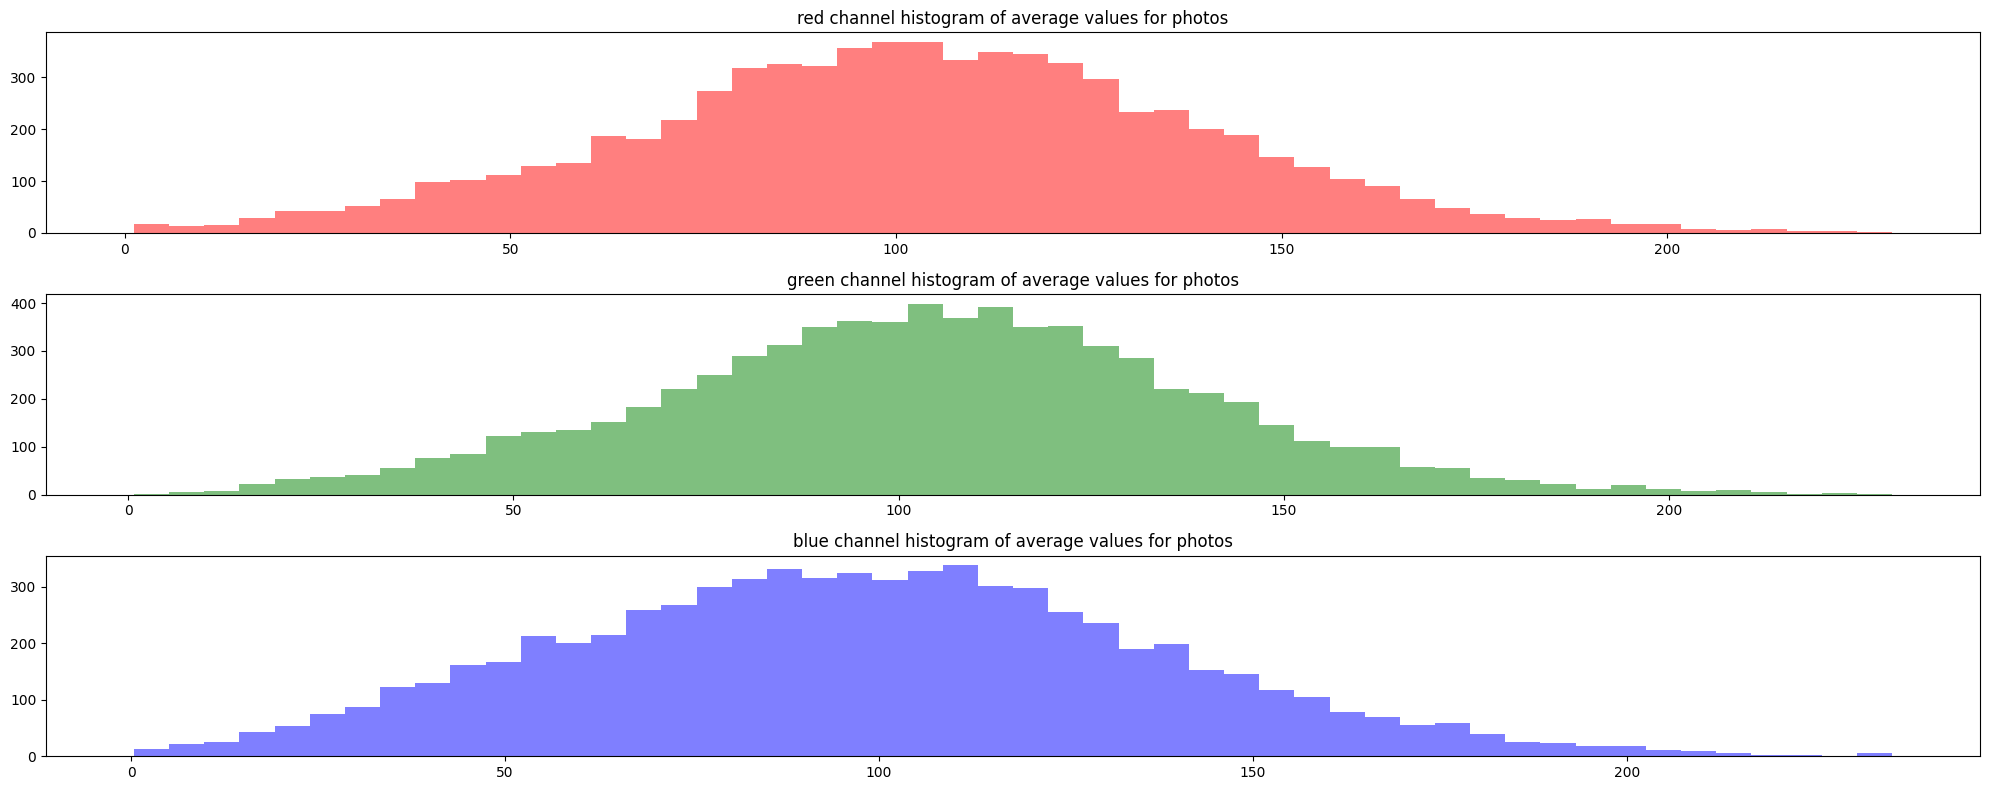

In [13]:
fig, axs = plt.subplots(3,1, figsize = (20,8))
channel_names = ["red","green","blue"]
for i,name in enumerate(channel_names):
    axs[i].hist(avg_photos[i].flatten(),color = name, alpha = 0.5, bins = 50)
    axs[i].set_title(name + " channel histogram of average values for photos")
plt.tight_layout()
plt.show()

These results are actually pretty ideal for both datasets, as the photos averages resemble gaussian distributions, and the monet averages seem vaguely gaussian, and may take that shape given more samples. The last metric to use will be standard deviation, which may reveal any outliers that we should remove.

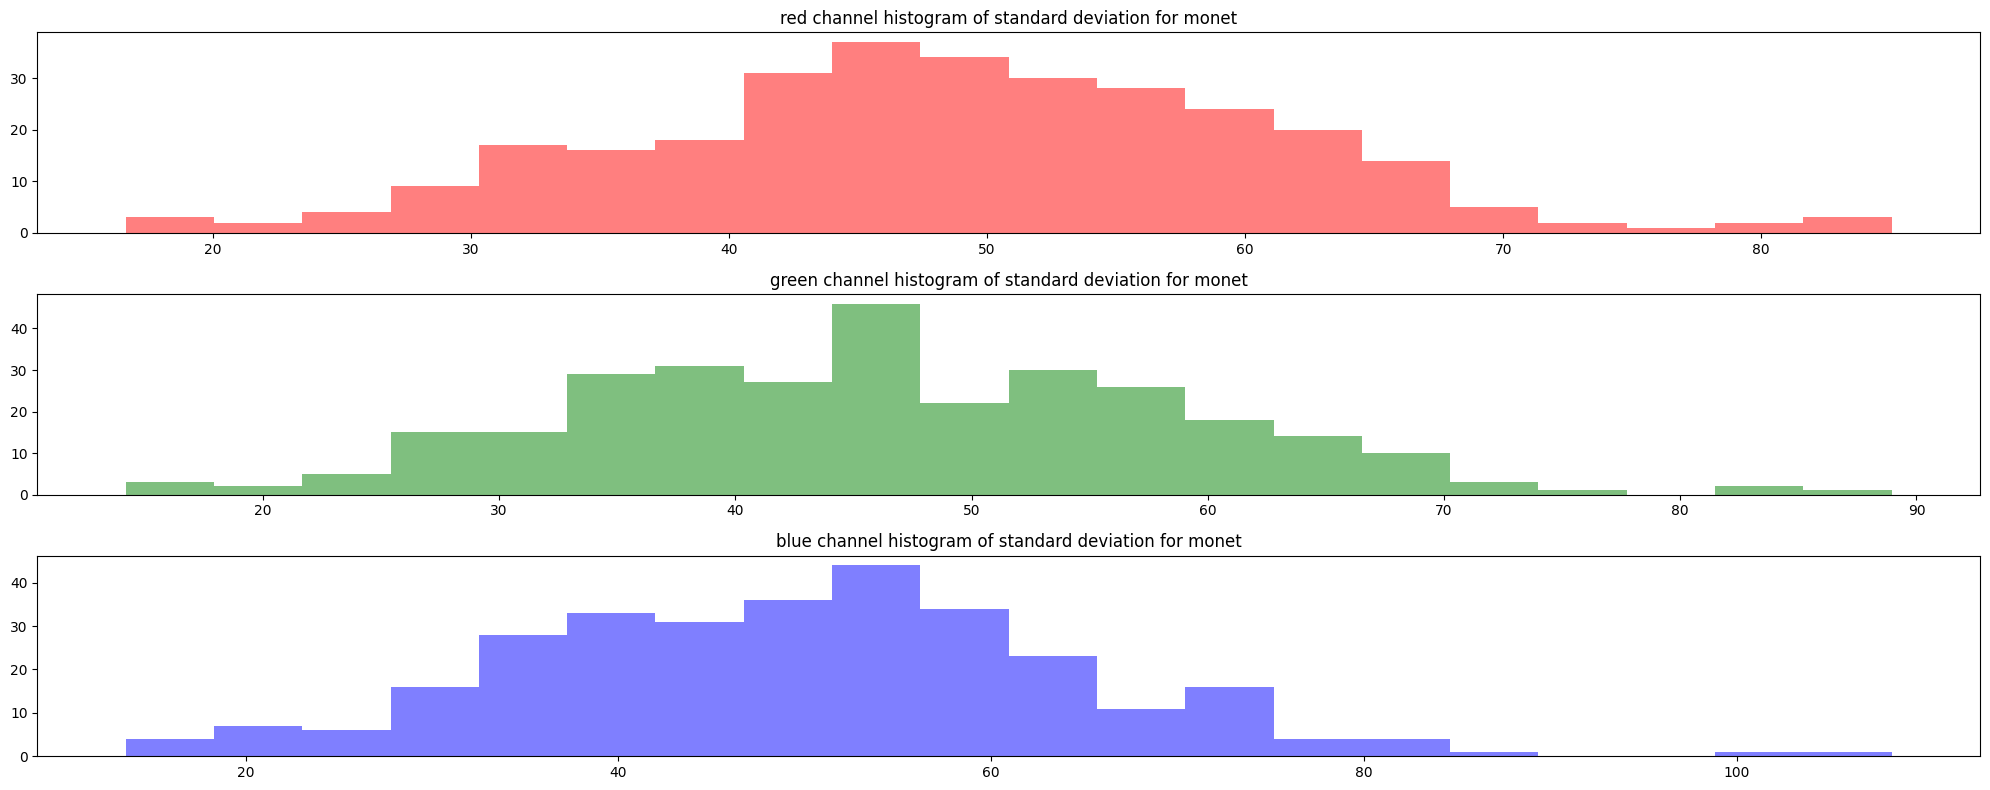

In [14]:
fig, axs = plt.subplots(3,1, figsize = (20,8))
channel_names = ["red","green","blue"]
for i,name in enumerate(channel_names):
    axs[i].hist(std_monet[i].flatten(),color = name, alpha = 0.5, bins = 20)
    axs[i].set_title(name + " channel histogram of standard deviation for monet")
plt.tight_layout()
plt.show()

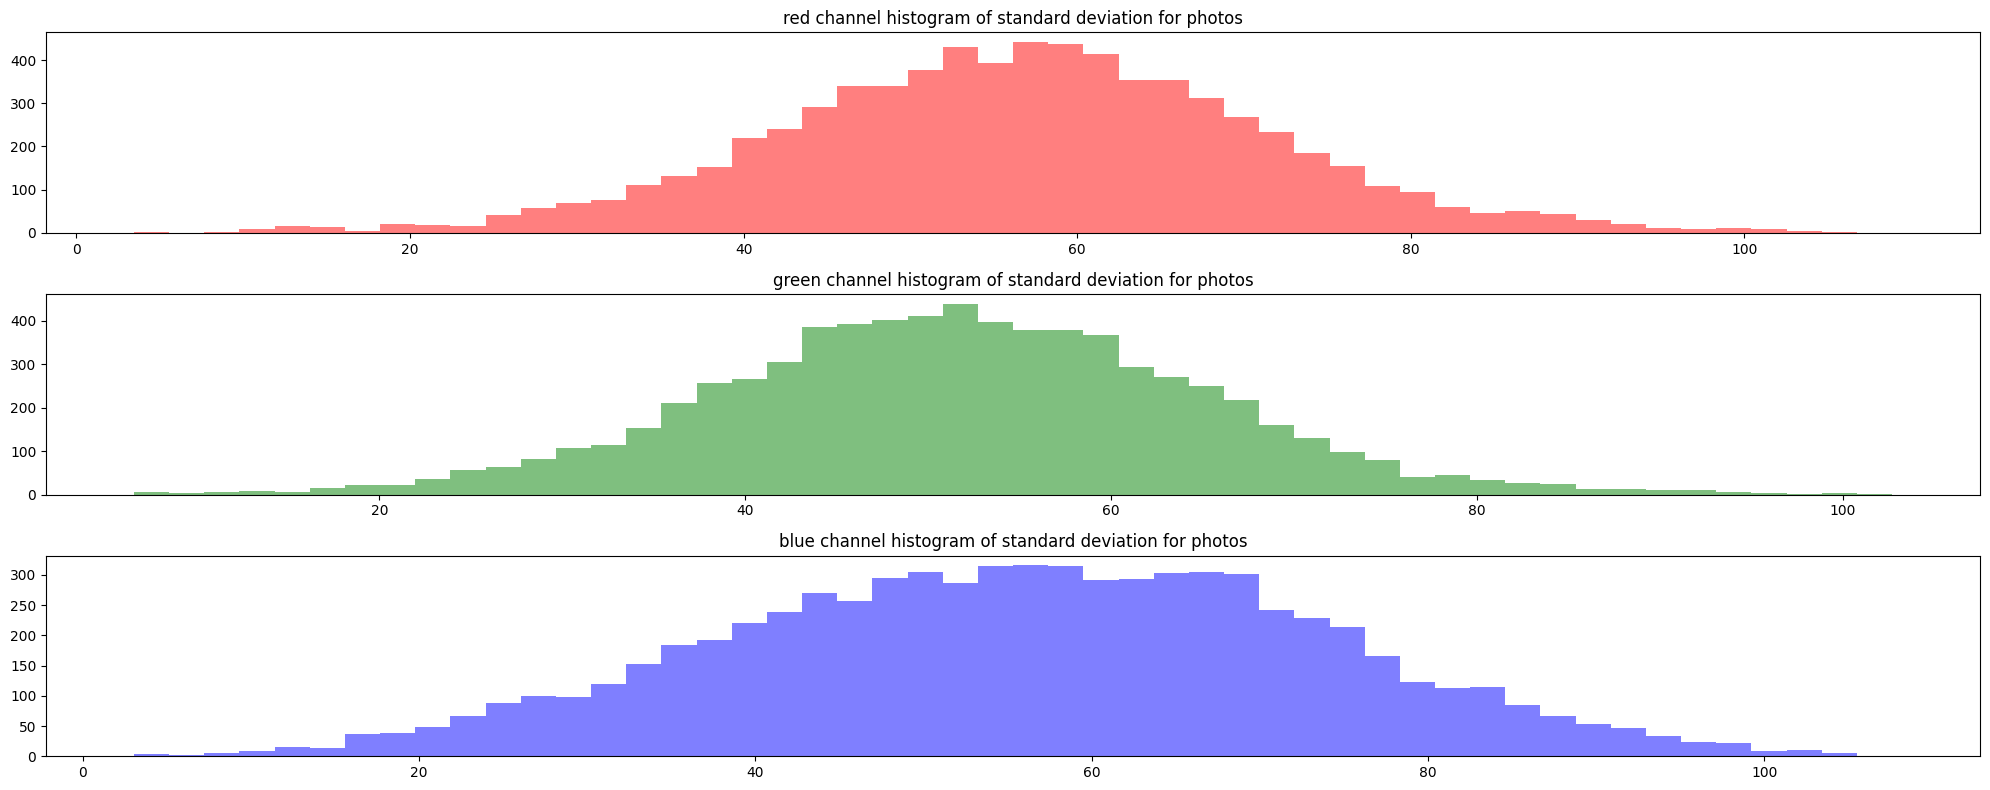

In [15]:
fig, axs = plt.subplots(3,1, figsize = (20,8))
channel_names = ["red","green","blue"]
for i,name in enumerate(channel_names):
    axs[i].hist(std_photos[i].flatten(),color = name, alpha = 0.5, bins = 50)
    axs[i].set_title(name + " channel histogram of standard deviation for photos")
plt.tight_layout()
plt.show()

Once again, we obtain neat, gaussian-like distributions for both datasets. These results suggest that both the training monet images and the photos for style transfer will serve as high-quality datasets with plenty of variety for the GAN to do what we want it to, without any outlier removal being necessary.

## __Model Architecture__

For this problem I tried utilized two different architectures for the discriminator and generator respectively, with one simple, and one complex. By making GAN's utilizing permutations of these models, Four Total GANs could be realized for this problem.

For each model, I trained them for 1000 epochs with a learning rate of 0.00002 for both the discriminator and generator respectively.

### _The simple generator_

Below is the simple generator done for this project. It has 64 filter dimensions persisting through the model. The encoder reduces the spatial features of the image by a factor of 4, and the decoder builds it back up after another convolutional layer. It utilized non-leaky ReLUs.

In [104]:
def make_simple_generator():
    generator_simple = Sequential(
        [
            Input(shape = (256,256,3)), #input image
            # Encoder layers break down features
            Conv2D(64,(3,3),padding = "same", activation = "relu"), 
            MaxPooling2D((2,2)), 

            # Decoder layers attempt to build it back up
            Conv2D(64,(3,3),padding = "same", activation = "relu"), 
            UpSampling2D((2,2)), 

            Conv2D(3, (3,3), activation = "tanh", padding = "same")
        ],
        name = "generator_simple"
    )
    return generator_simple
    
#separate simple generators must be used for actual training
G_S1 = make_simple_generator()
G_S2 = make_simple_generator()

Below is a summary of the simple generator

In [105]:
G_S1.summary()

Model: "generator_simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_118 (Conv2D)         (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_119 (Conv2D)         (None, 128, 128, 64)      36928     
                                                                 
 up_sampling2d_29 (UpSamplin  (None, 256, 256, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_120 (Conv2D)         (None, 256, 256, 3)       1731      
                                                                 
Total params: 40,451
Trainable params: 40,451
Non-

### _The complex generator_


Below is the complex generator done for this project. It has twice the number of convolutional blocks as the simple generator, expanding upon the encoder-decoder architecture of the simple generator, utilizing 128-filter Convolutional blocks. This new architecture also makes use of batch normalization and leaky relus to help stabilize the model.

In [106]:
def make_complex_generator():
    generator_complex = Sequential(
        [
            Input(shape = (256,256,3)),

            Conv2D(64,(3,3),padding = "same"),
            BatchNormalization(),
            LeakyReLU(alpha = 0.2),
            MaxPooling2D((2,2)),

            Conv2D(128, (3,3), padding = "same"),
            BatchNormalization(),
            LeakyReLU(alpha = 0.2),
            MaxPooling2D((2,2)),

            Conv2D(128, (3,3), padding = "same"),
            BatchNormalization(),
            LeakyReLU(alpha = 0.2),
            UpSampling2D((2,2)),

            Conv2D(64,(3,3),padding = "same"),
            BatchNormalization(),
            LeakyReLU(alpha = 0.2),
            UpSampling2D((2,2)),

            Conv2D(3, (3,3), activation = "tanh", padding = "same"),
        ],
        name = "generator_complex"
    )
    return generator_complex

G_C1 = make_complex_generator()
G_C2 = make_complex_generator()

Below is a summary of the complex generator and its features

In [107]:
G_C1.summary()

Model: "generator_complex"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_124 (Conv2D)         (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization_31 (Bat  (None, 256, 256, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_74 (LeakyReLU)  (None, 256, 256, 64)      0         
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_125 (Conv2D)         (None, 128, 128, 128)     73856     
                                                                 
 batch_normalization_32 (Bat  (None, 128, 128, 12

### _The simple discriminator_

The simple discriminator makes use of two convolutional blocks, each containing their own respective pooling layers. It makes use of a dropout of 0.3 to help mitigate overfitting, and also makes use of Leaky ReLUs, as is common for discriminators.

In [108]:
def make_simple_discriminator():
    discriminator_simple = Sequential(
        [
            Input(shape = (256,256,3)),

            Conv2D(64,(3,3),padding = "same"),
            LeakyReLU(alpha = 0.2),
            MaxPooling2D((2,2)),

            Conv2D(128,(3,3),padding = "same"),
            LeakyReLU(alpha = 0.2),
            MaxPooling2D((2,2)),

            Flatten(),
            Dropout(0.3),
            Dense(1,activation = "sigmoid")
        ],
        name = "discriminator"
    )
    return discriminator_simple

D_S1 = make_simple_discriminator()
D_S2 = make_simple_discriminator()

In [109]:
SD_1.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 256, 256, 64)      0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 128, 128, 128)     0         
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                

### _The Complex discriminator_

The complex discriminator only differs from the simpler version in that it features batch normalization, and has an extra convolutional block. The extra block doubles the filters and lowers the spatial dimensions further.

In [110]:
def make_complex_discriminator():
    discriminator_simple = Sequential(
        [
            Input(shape = (256,256,3)),

            Conv2D(64,(3,3),padding = "same"),
            BatchNormalization(),
            LeakyReLU(alpha = 0.2),
            MaxPooling2D((2,2)),

            Conv2D(128,(3,3),padding = "same"),
            BatchNormalization(),
            LeakyReLU(alpha = 0.2),
            MaxPooling2D((2,2)),

            Conv2D(256,(3,3),padding = "same"),
            BatchNormalization(),
            LeakyReLU(alpha = 0.2),
            MaxPooling2D((2,2)),

            Flatten(),
            Dropout(0.3),
            Dense(1,activation = "sigmoid")
        ],
        name = "discriminator"
    )
    return discriminator_simple

D_C1 = make_simple_discriminator()
D_C2 = make_simple_discriminator()

Below are some helper functions made for the training step of the model 

In [111]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def disc_loss(real_classified,fake_classified):
    #loss for incorrectly identified actual paintings
    real_loss = cross_entropy(tf.ones_like(real_classified),real_classified)
    #loss for incorrectly identified fake paintings
    fake_loss = cross_entropy(tf.zeros_like(fake_classified),fake_classified)    
    return real_loss + fake_loss

def gen_loss(fake_classified):
    return cross_entropy(tf.ones_like(fake_classified),fake_classified)

Below is what will perform a training step for the models

In [112]:
def training_step(content_images,style_images,generator,discriminator,g_optimizer,d_optimizer):
    # convert to tf float 32 to avoid potential conflicts
    content_images = tf.convert_to_tensor(content_images, dtype=tf.float32)
    style_images = tf.convert_to_tensor(style_images, dtype=tf.float32)
    
    # record operations
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # apply generator and train
        generated_images = generator(content_images, training=True)
        # apply discriminator and train
        real_output = discriminator(style_images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # gather losses 
        gen_loss_val = gen_loss(fake_output)
        disc_loss_val = disc_loss(real_output, fake_output)
        
    # calculate gradients
    generator_gradients = gen_tape.gradient(gen_loss_val, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss_val, discriminator.trainable_variables)
    # update the weights
    g_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    #return losses for analysis purposes
    return gen_loss_val,disc_loss_val


Below is the full training sequence for the GAN. I chose to randomly subsample a set of 50 images for each batch size per epoch, since the entire monet image set could not be visited at once. Yes, this does mean that an image may not be visited by the models for a while, but I figured it would impose variety onto the models each epoch

In [113]:

def train_GAN(style_images,transform_images,gen,disc,gen_opt,disc_opt,epochs = 1000,):

    batch_size = 50

    start_time = time.time()
    g_loss,d_loss = [],[]
    for epoch in range(epochs):
        random_monet_indices = np.random.choice(len(style_images),batch_size, replace = False)
        random_photo_indices = np.random.choice(len(transform_images),batch_size, replace = False)
        #print(random_photo_indices)
        monet_sampled = [train_images[i] for i in random_monet_indices]
        photo_sampled = [photo_images[i] for i in random_photo_indices]

        monet_sampled = np.array(monet_sampled)/127.5 -1
        photo_sampled = np.array(photo_sampled)/127.5 -1


        g_loss_t,d_loss_t = training_step(photo_sampled,monet_sampled,gen,disc,gen_opt,disc_opt)

        g_loss.append(g_loss_t)
        d_loss.append(d_loss_t)
    
    return g_loss,d_loss

## __Results and Analysis__

In this section, the loss of both the discriminator and generator are tracked during their training, and their relationship is used as a crude metric for how effectively the models are competing with one another.

In [124]:
#define learning rates
learning_rate_gen = 0.00002
learning_rate_disc = 0.00002

### _Simple Generator, Simple Discriminator_

Train the Simple-Simple model

In [115]:
gen_opt = Adam(learning_rate = learning_rate_gen)
disc_opt = Adam(learning_rate = learning_rate_disc)
G_loss1,D_loss1 = train_GAN(train_images,photo_images,G_S1,D_S1,gen_opt,disc_opt, epochs = 1000)

Plot the binary cross entropy loss of generator and discriminator

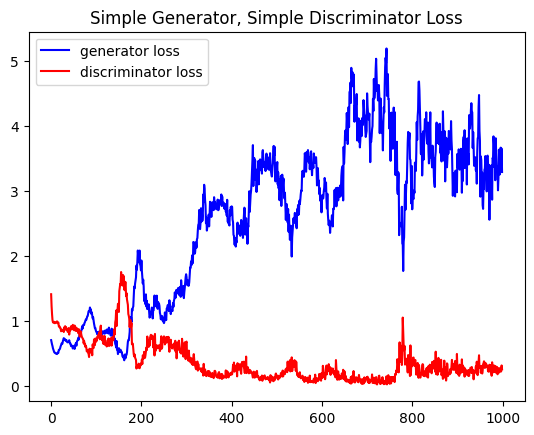

In [116]:
plt.title("Simple Generator, Simple Discriminator Loss")
plt.plot(np.arange(len(G_loss1)),G_loss1, c = "blue")
plt.plot(np.arange(len(D_loss1)), D_loss1, c = "red")
leg = ["generator loss", "discriminator loss"]
plt.legend(leg)

The above is a clear example of a dominant discriminator. it appears that as soon as the discriminator's loss became too high after that first big peak, it overcorrected and became too strong for the generator to keep up. Eventually the discriminator becomes very confident, which causes the generator's gradients vanish, and its growth to stagnate. This long-term instability shows that these architectures with their given hyperparameters make for a poor GAN

### _Simple Generator, Complex Discriminator_

Train the Simple-Complex Model

In [117]:
gen_opt = Adam(learning_rate = learning_rate_gen)
disc_opt = Adam(learning_rate = learning_rate_disc)
G_loss2,D_loss2 = train_GAN(train_images,photo_images,G_S2,D_C1,gen_opt,disc_opt, epochs = 1000)

Plot the binary cross entropy loss of generator and discriminator

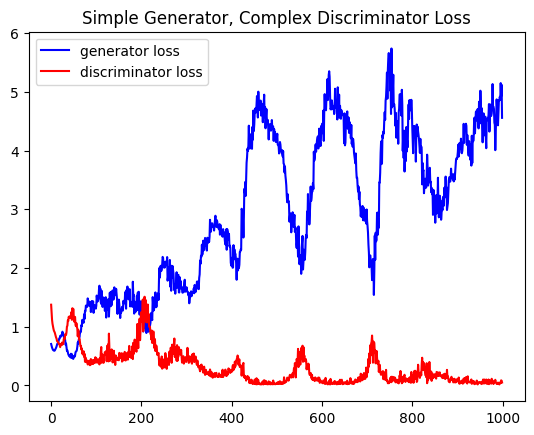

In [121]:
plt.title("Simple Generator, Complex Discriminator Loss")
plt.plot(np.arange(len(G_loss2)),G_loss2, c = "blue")
plt.plot(np.arange(len(D_loss2)), D_loss2, c = "red")
leg = ["generator loss", "discriminator loss"]
plt.legend(leg)

Here we see an even worse example of a dominant discriminator. Not only does it dominate, but in each instance where the generator is able to start improving its performance, the discriminator is able to swiftly adapt to it, and raise the generator's loss to even newer heights. These models are an even worse match for one another than the last.

### _Complex Generator, Simple Discriminator_

Train the Model

In [118]:
gen_opt = Adam(learning_rate = learning_rate_gen)
disc_opt = Adam(learning_rate = learning_rate_disc)
G_loss3,D_loss3 = train_GAN(train_images,photo_images,G_C1,D_S2,gen_opt,disc_opt, epochs = 1000)

Plot the binary cross entropy loss of generator and discriminator

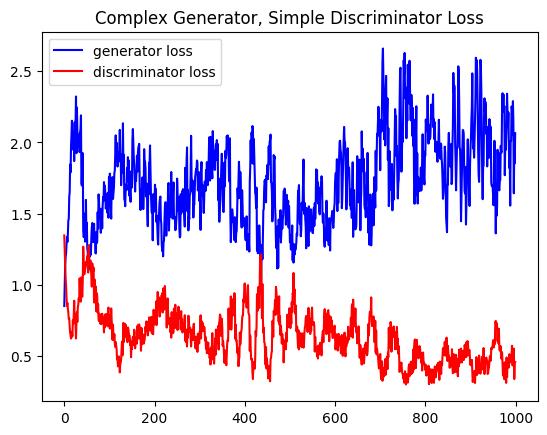

In [144]:
plt.title("Complex Generator, Simple Discriminator Loss")
plt.plot(np.arange(len(G_loss3)),G_loss3, c = "blue")
plt.plot(np.arange(len(D_loss3)), D_loss3, c = "red")
leg = ["generator loss", "discriminator loss"]
plt.legend(leg)

Here we're able to see some reasonable adversarial behavior between the two models, where the generator and discriminator are able to train without actively harming the growth of the other. In the plot, although the generator does do much better than it has in previous versions, the discriminator is still largely somewhat dominating the situation, possibly even starting to show signs of diverging since the two metrics grow apart over the course of the epochs. The models are not a terrible fit, but we can do better

In [119]:
gen_opt = Adam(learning_rate = learning_rate_gen)
disc_opt = Adam(learning_rate = learning_rate_disc)
G_loss4,D_loss4 = train_GAN(train_images,photo_images,G_C2,D_C2,gen_opt,disc_opt, epochs = 1000)

### _Complex Generator, Complex Discriminator_

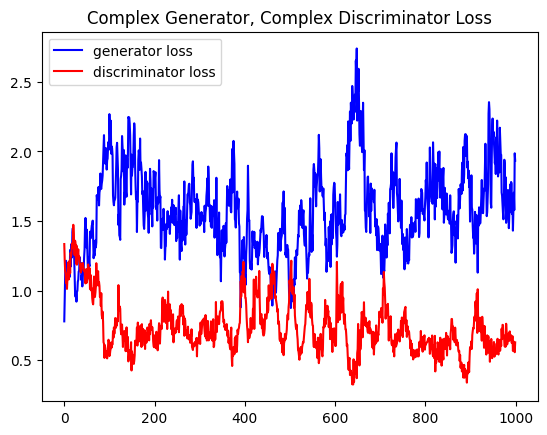

In [150]:
plt.title("Complex Generator, Complex Discriminator Loss")
plt.plot(np.arange(len(G_loss4)),G_loss4, c = "blue")
plt.plot(np.arange(len(D_loss4)), D_loss4, c = "red")
leg = ["generator loss", "discriminator loss"]
plt.legend(leg)

The above result suggest that the discriminator is experiencing ebbs and flows for it's loss, and in more than a few instances actually has higher loss than the generator. While the discriminator's loss does seems to self-correct with every decrease in the generator's loss, it never seems to outright dominate, even at the higher epochs. It does seem like there's some general instability in this model that's higher than the previous one.

Interestingly, the results thus far show the "complex" discriminator to be the worse of the two, but it's worse performance allows it to be more in-tune with the generators used in this project.

Based on these results, I'll do the remaining analysis using the Complex-Complex model

In [145]:
transformed_images = []
#process the complex images in batches, and append them to a list
batch_size = 50
batches = len(photo_images)//batch_size
b_i = 0
for n in range(batches):

    images = (photo_images[b_i:b_i + batch_size]/127.5 - 1)
    transformed = G_C2(images,training=False).numpy()
    transformed = ((np.array(transformed) +1)*127.5).astype(np.uint8)

    for image in transformed:
        transformed_images.append(image)

    b_i += batch_size

Now, let's see how that first photo changes when ran through our best trained generator

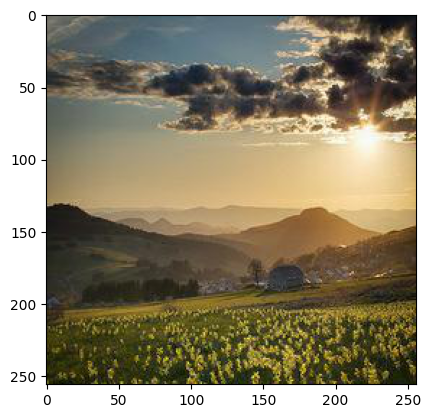

In [153]:
#first photo
plt.imshow(photo_images[0])

below is the result

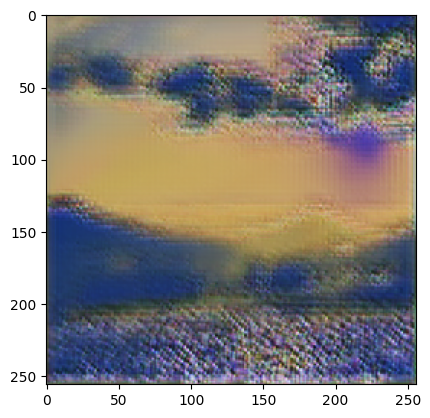

In [147]:
plt.imshow(transformed_images[0])

monet picture for comparison

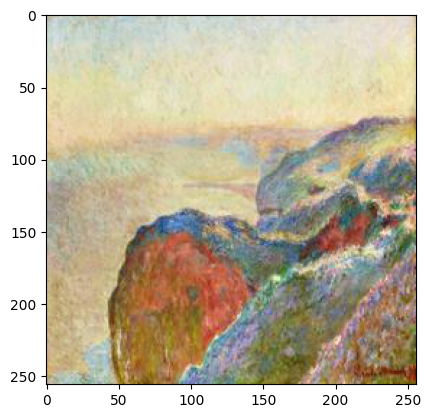

In [149]:
plt.imshow(train_images[0])

Upon visual inspection, this result actually looks quite good, and the result actually looks vaguely monet-esque. However, it's lack of detail does leave much to be desired.

Lastly, let's look at how the image values of the dataset have changed

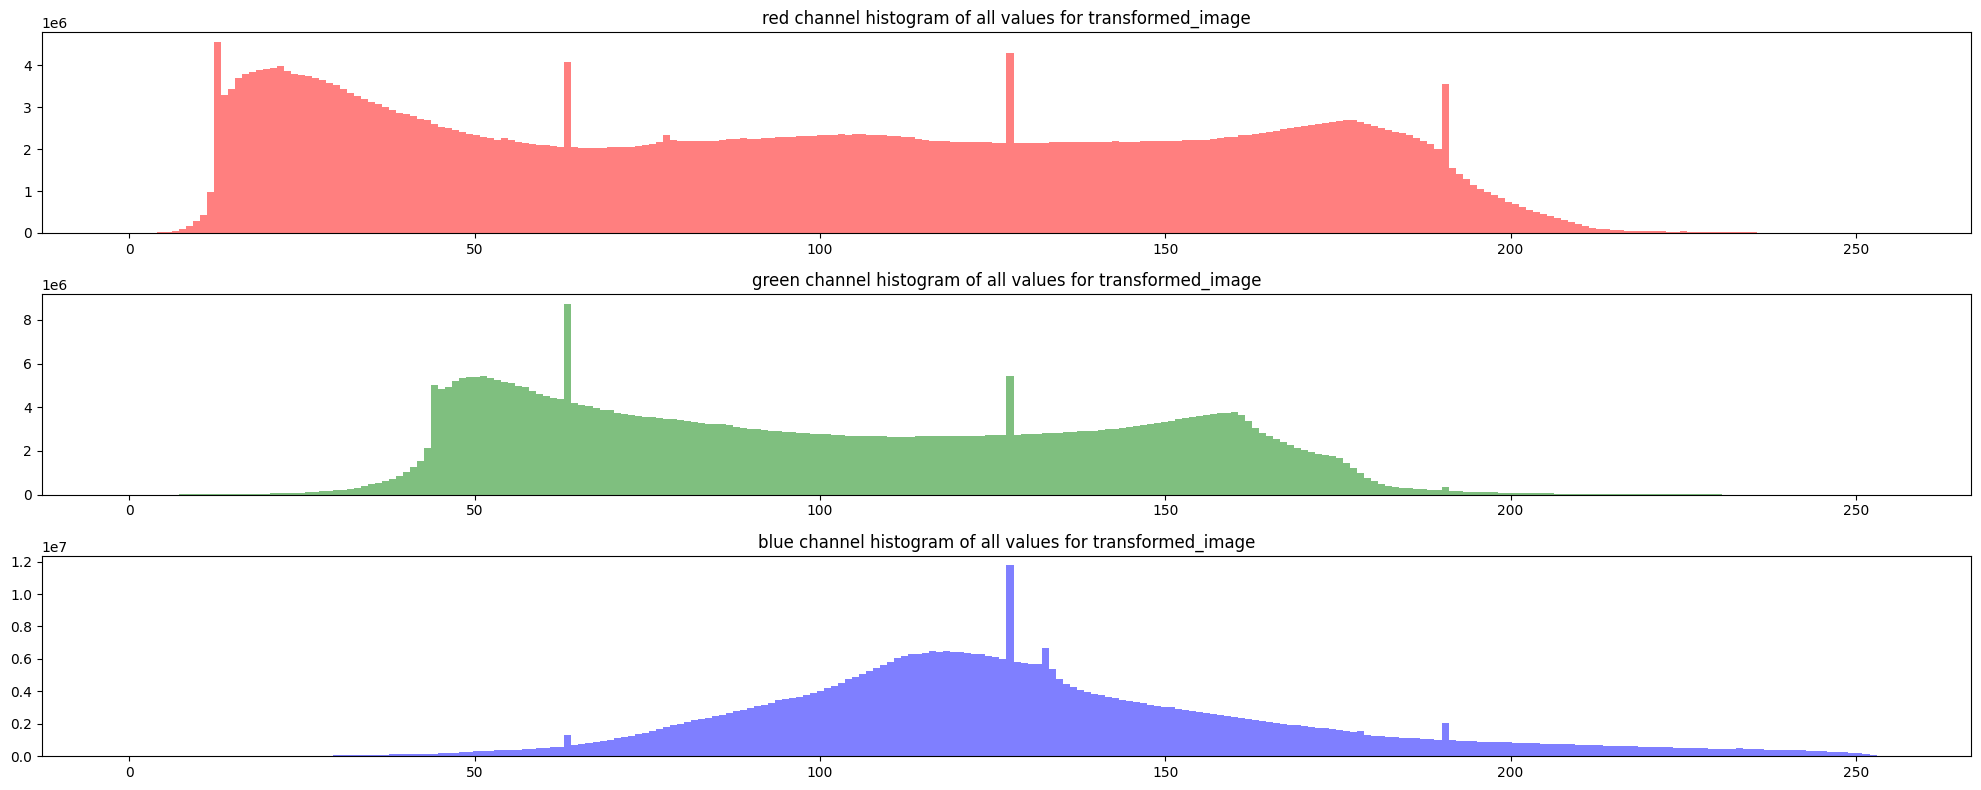

In [148]:
transformed_images = np.array(transformed_images)
all_v_transformed = [transformed_images[:,:,:,i] for i in range(3)]

fig, axs = plt.subplots(3,1, figsize = (20,8))
channel_names = ["red","green","blue"]
for i,name in enumerate(channel_names):
    axs[i].hist(all_v_transformed[i].flatten(),color = name, alpha = 0.5, bins = 250)
    axs[i].set_title(name + " channel histogram of all values for transformed_image")
plt.tight_layout()
plt.show()

these results are strange, and the multimodality of these suggest that the model has decided to focus on some particular colors during training, which is a feature not present in the monet histograms.

Generally, a GAN was created capable of generating vaguely monet-esque images, albeit with some caveats. The GAN's that performed the best were generally those with higher-depth, more complex architectures for their generators, for those tested.

The ever-present challenge with this project was finding vaguely compatible architectures that could "get along" for 1000 epochs. Finding the proper batch size was also difficult, as too low a batch size meant potentially introducing instability, but too high a batch size would cause disproportionately high increases in training time. Not only this, but the RAM and VRAM limitations within the kaggle notebook also proved to be an issue, as none of the architectures I used could actually run in any of their offered frameworks, and vectorized operations had to be performed with care. Because of this, the only models successfully run in the kaggle notebook thus far was the Simple-Simple model, the second worst performing setup out of those found, which is a shame. 

## __Conclusion__

Ultimately, I was quite happy with the result of my style transfer GAN, and it seemed capable of actually transfering some semblance of Monet's style to real-world photos. Unfortunately, the only model that I was actually able to submit to kaggle due to VRAM limitations was my second worst one. It obtained a below average score of about 94, which is to be expected given the overly-dominating discriminator.

It interesting to see how large a role the variation in architecture could have in the model, and how employing a "worse" model on one side of the GAN was actually able to improve the model as a whole, as the power of the models were now more closely balanced. Improving the underperforming side of the model seemed to make the largest difference however, as only the models with the more complex generator architecture did not cascade into vanishing gradients during the 1000 epochs of training.

Improvements that could be made to the model could be done in the form of "skipping" the training of one of the models, if it's performing too well compared to the other. This would allow the underperforming model "extra time" to catch up, and may function well to impose a forced equilibrium upon the two, even if the models are not well-suited to one another. Lastly another potential improvement to the model that could be made would be the obvious further tuning of hyperparameters.